# Physics-enhanced regression

Aka Phenrir (Fenrir). 

In [1]:
import functools

import jax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import dense_output, ivpsolve, solvers
from odefilter.implementations import isotropic
from odefilter.strategies import smoothers

config.update("jax_enable_x64", True)

if not backend.has_been_selected:
    backend.select("jax")

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()
f_args = jnp.asarray(f_args)

parameter_true = f_args + 0.05
parameter_guess = f_args


@jax.jit
def vf(y, t, p):
    return f(y, *p)

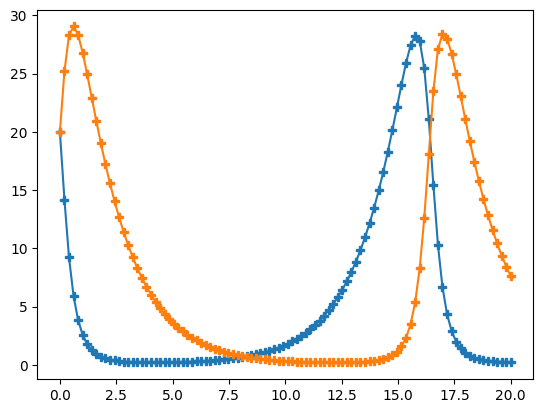

In [3]:
# make data

ts = jnp.linspace(t0, t1, endpoint=True, num=100)

strategy = smoothers.Smoother(
    extrapolation=isotropic.IsoIBM.from_params(num_derivatives=1),
)
solver = solvers.Solver(strategy=strategy, output_scale_sqrtm=10.0)


solution_true = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), ts=ts, solver=solver, parameters=parameter_true
)
data = solution_true.u
plt.plot(ts, data, "P-")
plt.show()

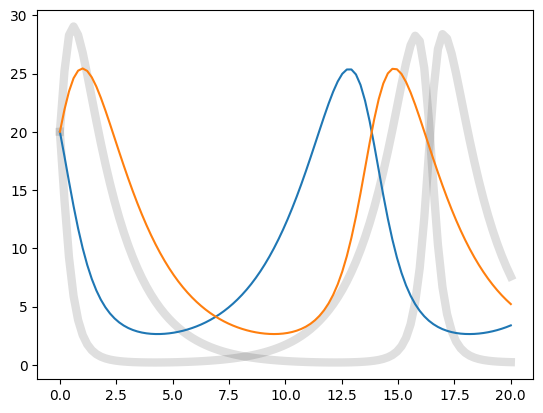

In [4]:
solution_wrong = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), ts=ts, solver=solver, parameters=parameter_guess
)
plt.plot(ts, data, color="k", linestyle="solid", linewidth=6, alpha=0.125)
plt.plot(ts, solution_wrong.u)
plt.show()

In [5]:
def data_likelihood(parameters_, u0_, ts_, solver_, vf_, data_):
    sol_ = ivpsolve.solve_fixed_grid(
        vf_, initial_values=(u0_,), ts=ts_, solver=solver_, parameters=parameters_
    )

    observation_std = jnp.ones_like(ts_) * 1e-1
    return dense_output.negative_marginal_log_likelihood(
        observation_std=observation_std, u=data_, solution=sol_, solver=solver_
    )


parameter_to_solution = jax.jit(
    functools.partial(
        data_likelihood, solver_=solver, ts_=ts, vf_=vf, u0_=u0, data_=data
    )
)
sensitivity = jax.jit(jax.grad(parameter_to_solution))

In [6]:
%%time

parameter_to_solution(parameter_guess)
sensitivity(parameter_guess)

CPU times: user 3.56 s, sys: 7.01 ms, total: 3.56 s
Wall time: 3.68 s


DeviceArray([44.80069421, 68.46055784, 51.8853719 , 24.4436413 ], dtype=float64)

In [7]:
%%time

f1 = parameter_guess
lrate = 2e-6
block_size = 50
for i in range(block_size):
    for _ in range(block_size):
        f1 = f1 - lrate * sensitivity(f1)

    print(f"After {(i+1)*block_size} iterations:", f1, parameter_true)


print(f1, parameter_true)

After 50 iterations: [0.49628904 0.04267043 0.4958443  0.04329479] [0.55 0.1  0.55 0.1 ]
After 100 iterations: [0.49454801 0.02896809 0.49383302 0.03064383] [0.55 0.1  0.55 0.1 ]
After 150 iterations: [0.49342497 0.02190132 0.49246409 0.02801388] [0.55 0.1  0.55 0.1 ]
After 200 iterations: [0.49223362 0.02189775 0.49123913 0.02809844] [0.55 0.1  0.55 0.1 ]
After 250 iterations: [0.49098355 0.02189719 0.48995417 0.02818946] [0.55 0.1  0.55 0.1 ]
After 300 iterations: [0.48967029 0.0218981  0.48860445 0.02828813] [0.55 0.1  0.55 0.1 ]
After 350 iterations: [0.48828864 0.0219008  0.48718456 0.02839564] [0.55 0.1  0.55 0.1 ]
After 400 iterations: [0.48683256 0.02190568 0.4856882  0.02851347] [0.55 0.1  0.55 0.1 ]
After 450 iterations: [0.48529497 0.02191323 0.48410797 0.02864352] [0.55 0.1  0.55 0.1 ]
After 500 iterations: [0.48366744 0.02192412 0.48243506 0.02878822] [0.55 0.1  0.55 0.1 ]
After 550 iterations: [0.48193977 0.02193921 0.48065875 0.0289508 ] [0.55 0.1  0.55 0.1 ]
After 600 i

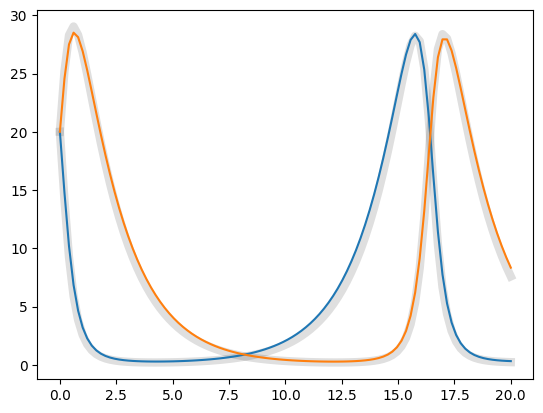

In [8]:
solution_wrong = ivpsolve.solve_fixed_grid(
    vf, initial_values=(u0,), ts=ts, solver=solver, parameters=f1
)
plt.plot(ts, data, color="k", linestyle="solid", linewidth=6, alpha=0.125)
plt.plot(ts, solution_wrong.u)
plt.show()